In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.ticker
import FilterShapes as filters
import audio_dspy as adsp
import sounddevice as sd
from scipy.io.wavfile import read
import soundfile as sf

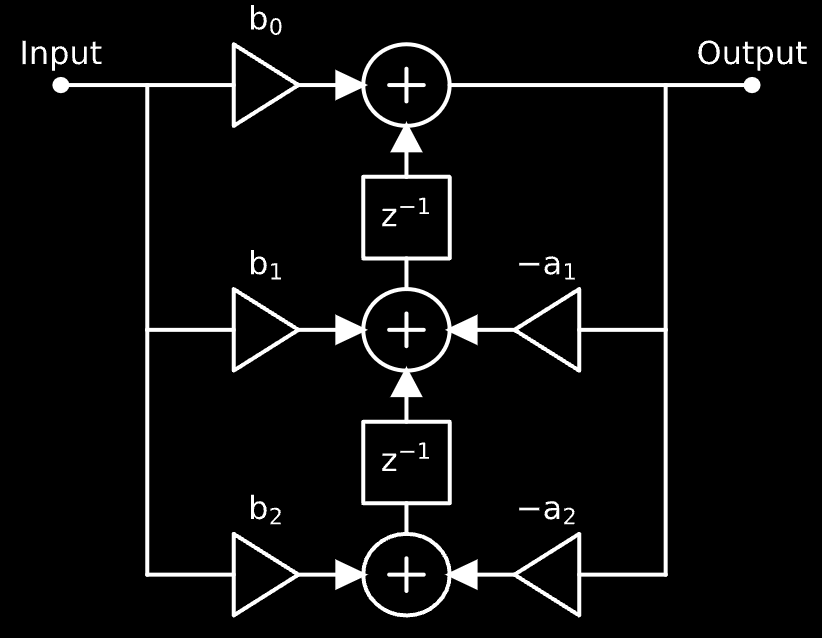

In [39]:
def chirpLog (f0, f1, duration, fs):
    N = int (duration * fs)
    n = np.arange (N)
    
    beta = N / np.log(f1 / f0)
    phase = 2 * np.pi * beta * f0 * (pow(f1 / f0, n / N) - 1.0)
    phi = np.pi / 180
       
    return np.cos ((phase + phi)/fs)

def chrp2ir (ss, rs):
    N = max (len (rs), len (ss))
    SS = np.fft.fft (ss, n=N)
    RS = np.fft.fft (rs, n=N)
    
    H = RS/SS
    h = np.real (np.fft.ifft (H))
    return h

class Biquad:
    def __init__ (self):
        self.z = np.zeros (3)
        self.b = np.array ([1, 0, 0])
        self.a = np.array ([1, 0, 0])
        self.saturator = lambda x : np.tanh(x)
    
    def setCoefs (self, b, a):
        assert (np.size (b) == np.size (self.b))
        assert (np.size (a) == np.size (self.a))
        self.b = np.copy (b)
        self.a = np.copy (a)

    # Direct-Form II, transposed
    def processSample (self, x):
        y = self.z[1] + self.b[0]*x
        self.z[1] = self.saturator (self.z[2] + self.b[1]*x - self.a[1]*y)
        self.z[2] = self.saturator (self.b[2]*x - self.a[2]*y)
        return y

    def processBlock (self, block):
        for n in range (len (block)):
            block[n] = self.processSample (block[n])
        return block

In [40]:
def plotFilterResponse (biquad, fs, gain=0.1):
    x = gain*chirpLog (20, 20000, 1, fs)
    y = biquad.processBlock (np.copy (x))
    N = len (x)

    h = chrp2ir (x, y)

    f = np.linspace (0, fs/2, num=N/2+1)
    H = np.fft.rfft (h)
    plt.semilogx (f, 20 * np.log10 (np.abs (H)))

def plotNonlinearFilterResponse (b, a, title, gains=[0.5, 0.25, 0.1]):
    plt.figure()
    legend = []
    for gain in gains:
        nlBQ = Biquad()
        nlBQ.setCoefs (b, a)
        nlBQ.saturator = lambda x : np.tanh (x)
        plotFilterResponse (nlBQ, fs, gain=gain)
        legend.append ('Nonlinear (gain={})'.format (gain))

    normalBQ = Biquad()
    normalBQ.setCoefs (b, a)
    plotFilterResponse (normalBQ, fs)
    legend.append ('Linear')

    plt.xlim (20, 20000)
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.title (title)
    plt.xlabel ('Frequency [Hz]')
    plt.ylabel ('Magnitude [dB]')
    plt.legend (legend)


In [41]:
fs = 44100
b, a = filters.calcCoefsLowShelf (1000, 0.707*2, 2, fs)
plotNonlinearFilterResponse (b, a, 'Nonlinear Low Shelf')

TypeError: 'float' object cannot be interpreted as an integer

<Figure size 640x480 with 0 Axes>

In [26]:
#f0 = 20
#f1 = 20000
freq = 440
duration = 5
fs = 44100
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Generate sine wave
x = 0.5 * np.sin(2 * np.pi * freq * t)

# N = int(duration * fs)
# n = np.arange(N)

# beta = N / np.log(f1 / f0)
# phase = 2 * np.pi * beta * f0 * (pow(f1 / f0, n / N) - 1.0)
# phi = np.pi / 180

# x = np.cos((phase + phi) / fs) # generate sin sweep

In [4]:
data, fs = sf.read('drums.wav')
sd.play(data*0.5, fs)

In [5]:
x = data[:,0]

In [27]:
sd.play(x, fs)

In [34]:
#x = 0.1 * x
b, a = filters.calcCoefsLowShelf(1000, 0.707*2, 10, fs)
nlBQ = Biquad()
nlBQ.setCoefs(b, a)
nlBQ.saturator = lambda x : np.tanh(x)
y = nlBQ.processBlock (np.copy (x))

# for i in range(len(x)):
#     y[i] = nlBQ.processBlock (np.copy(x))


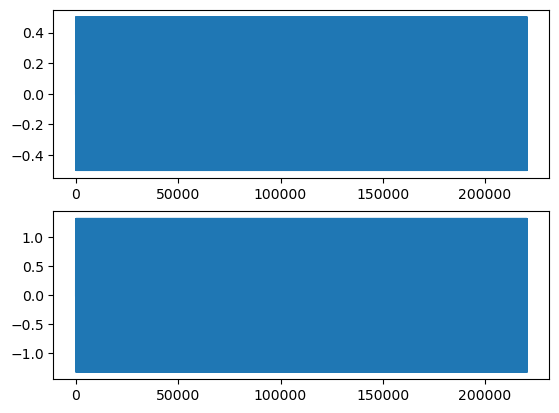

In [30]:
plt.subplot(2, 1, 1)
#plt.plot(data[:,0])
plt.plot(x)
plt.subplot(2, 1, 2)
plt.plot(y)


In [22]:
sd.play(data * 0.5, fs)

In [35]:
sd.play(y * 0.5, fs)